In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchmetrics.functional as metrics
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import WeightedRandomSampler
from torchvision.datasets import ImageFolder
from torchvision import transforms
from PIL import Image
from torchvision.models import resnet18, ResNet18_Weights
from torch.nn.init import kaiming_normal
from torchinfo import summary

In [28]:
# 이미지 사이즈 맞추고 텐서화
preprocessing = transforms.Compose([
    transforms.Resize((32,32)),
    # ToTensor() -> 0~1의 값으로 정규화
    transforms.ToTensor()
])

In [29]:
img_root = '../data/image/SMALL'

dataDS = ImageFolder(root=img_root, transform=preprocessing)

In [30]:
dataDS.classes = [label.replace('_small', '') for label in dataDS.classes]

In [31]:
dataDS.class_to_idx = {new_class: idx for idx, new_class in enumerate(dataDS.classes)}

In [32]:
dataDS.classes

['Affenpinscher',
 'AutralianTerrier',
 'BorderTerrier',
 'BrabanconGriffon',
 'CairnTerrier',
 'Chihuahua',
 'Japanesespaniel',
 'LakelandTerrier',
 'Lhasa',
 'Maltese',
 'MexicanHairless',
 'MiniaturePoodle',
 'NorfolkTerrier',
 'NorwichTerrier',
 'Papillon',
 'Pekinese',
 'Pomeranian',
 'Pug',
 'SealyhamTerrier',
 'ShihTzu',
 'SilkyTerrier',
 'ToyPoodle',
 'ToyTerrier',
 'WireFoxTerrier',
 'YorkshireTerrier']

In [33]:
dataDS.class_to_idx, len(dataDS.classes)

({'Affenpinscher': 0,
  'AutralianTerrier': 1,
  'BorderTerrier': 2,
  'BrabanconGriffon': 3,
  'CairnTerrier': 4,
  'Chihuahua': 5,
  'Japanesespaniel': 6,
  'LakelandTerrier': 7,
  'Lhasa': 8,
  'Maltese': 9,
  'MexicanHairless': 10,
  'MiniaturePoodle': 11,
  'NorfolkTerrier': 12,
  'NorwichTerrier': 13,
  'Papillon': 14,
  'Pekinese': 15,
  'Pomeranian': 16,
  'Pug': 17,
  'SealyhamTerrier': 18,
  'ShihTzu': 19,
  'SilkyTerrier': 20,
  'ToyPoodle': 21,
  'ToyTerrier': 22,
  'WireFoxTerrier': 23,
  'YorkshireTerrier': 24},
 25)

In [34]:
dataDS.imgs

[('../data/image/SMALL\\Affenpinscher_small\\n02110627_10147.jpg', 0),
 ('../data/image/SMALL\\Affenpinscher_small\\n02110627_10185.jpg', 0),
 ('../data/image/SMALL\\Affenpinscher_small\\n02110627_10225.jpg', 0),
 ('../data/image/SMALL\\Affenpinscher_small\\n02110627_10437.jpg', 0),
 ('../data/image/SMALL\\Affenpinscher_small\\n02110627_10439.jpg', 0),
 ('../data/image/SMALL\\Affenpinscher_small\\n02110627_10447.jpg', 0),
 ('../data/image/SMALL\\Affenpinscher_small\\n02110627_10680.jpg', 0),
 ('../data/image/SMALL\\Affenpinscher_small\\n02110627_10787.jpg', 0),
 ('../data/image/SMALL\\Affenpinscher_small\\n02110627_10848.jpg', 0),
 ('../data/image/SMALL\\Affenpinscher_small\\n02110627_10859.jpg', 0),
 ('../data/image/SMALL\\Affenpinscher_small\\n02110627_10986.jpg', 0),
 ('../data/image/SMALL\\Affenpinscher_small\\n02110627_11211.jpg', 0),
 ('../data/image/SMALL\\Affenpinscher_small\\n02110627_11262.jpg', 0),
 ('../data/image/SMALL\\Affenpinscher_small\\n02110627_11263.jpg', 0),
 ('../

In [35]:
img = []
label = []
for image_path,la in dataDS.imgs:
    image = Image.open(image_path)
    image = preprocessing(image) 
    img.append(image)
    label.append(la)

In [36]:
x_train, x_val, y_train, y_val = train_test_split(img,label,test_size=0.1,stratify=label,random_state=4)

In [37]:
class DLDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.feature = x_data
        self.target = y_data

        
    def __len__(self):
        return len(self.feature)

    def __getitem__(self, index):
        image_tensor = self.feature[index]
        label = self.target[index]
        return image_tensor, label

In [38]:
trainDS = DLDataset(x_train,y_train)
validDS = DLDataset(x_val,y_val)

In [39]:
pd.Series(trainDS.target).value_counts(), len(pd.Series(trainDS.target).value_counts())

(9     214
 16    197
 19    186
 18    182
 4     177
 7     177
 1     176
 17    175
 14    175
 8     167
 6     166
 13    165
 20    163
 2     155
 12    154
 22    154
 24    145
 10    140
 23    140
 11    139
 3     137
 21    135
 0     134
 15    129
 5     125
 Name: count, dtype: int64,
 25)

In [40]:
# 이미지의 shape 확인
trainDS[0][0].shape, validDS[0][0].shape

(torch.Size([3, 32, 32]), torch.Size([3, 32, 32]))

In [41]:
# 높이, 너비를 기준으로 채널의 평균과 표준편차 구하기
meanRGB = [np.mean(f.numpy(), axis=(1,2)) for f,l in trainDS]
stdRGB = [np.std(f.numpy(), axis=(1,2)) for f,l in trainDS]

In [42]:
meanR = np.mean([i[0] for i in meanRGB])
meanG = np.mean([i[1] for i in meanRGB])
meanB = np.mean([i[2] for i in meanRGB])

stdR = np.std([i[0] for i in stdRGB])
stdG = np.std([i[1] for i in stdRGB])
stdB = np.std([i[2] for i in stdRGB])

In [43]:
normalize = transforms.Normalize(mean=[meanR, meanG, meanB], std=[stdR, stdG, stdB])

# 데이터셋 내의 모든 이미지에 대해 정규화 진행
trainDS = [(normalize(img), label) for img, label in trainDS]
validDS = [(normalize(img), label) for img, label in validDS]

In [44]:
from collections import Counter # 요소의 개수 반환 : dict

# 클래스별 비율 계산
train_class = {label: count / len(trainDS) for label, count in Counter([label for _, label in trainDS]).items()}
valid_class = {label: count / len(validDS) for label, count in Counter([label for _, label in validDS]).items()}


train_class, valid_class 

({14: 0.04367357125031195,
  10: 0.03493885700024956,
  13: 0.04117793860743699,
  19: 0.04641876715747442,
  22: 0.03843274270027452,
  3: 0.03419016720738707,
  23: 0.03493885700024956,
  8: 0.04167706513601198,
  1: 0.04392313451459945,
  2: 0.038682305964562014,
  20: 0.04067881207886199,
  15: 0.0321936610930871,
  4: 0.044172697778886945,
  9: 0.053406538557524336,
  16: 0.049163963064636884,
  18: 0.04542051410032443,
  5: 0.031195408035937112,
  0: 0.03344147741452458,
  12: 0.03843274270027452,
  11: 0.034689293735962065,
  21: 0.03369104067881208,
  7: 0.044172697778886945,
  17: 0.04367357125031195,
  24: 0.03618667332168705,
  6: 0.04142750187172448},
 {3: 0.033632286995515695,
  6: 0.04035874439461883,
  11: 0.033632286995515695,
  7: 0.04484304932735426,
  17: 0.04484304932735426,
  5: 0.03139013452914798,
  13: 0.04035874439461883,
  22: 0.03811659192825112,
  14: 0.04484304932735426,
  2: 0.03811659192825112,
  23: 0.03587443946188341,
  16: 0.04932735426008968,
  9: 0.

In [45]:
SAMPLER = WeightedRandomSampler(weights=[train_class[label] for _,label in trainDS], num_samples=len(trainDS), replacement=True)

BATCH = 32
# DataLoader 생성
trainDL = DataLoader(trainDS, batch_size=BATCH, sampler=SAMPLER)
validDL = DataLoader(validDS, batch_size=BATCH)

In [46]:
for images, labels in trainDL:
    print("Batch Shape:", images.shape)
    break

Batch Shape: torch.Size([32, 3, 32, 32])


In [53]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)  # 배치 정규화 층 추가
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)  # 배치 정규화 층 추가

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.input = nn.Linear(32 * 8 * 8, 128) 
        self.hidden2 = nn.Linear(64,32)
        self.output = nn.Linear(32, 25) 
    
        # 각 층에 대한 가중치 초기화 - like VGG
        nn.init.kaiming_uniform_(self.conv1.weight)
        nn.init.kaiming_uniform_(self.conv2.weight)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # 배치 정규화 적용
        x = F.relu(x)
        x = self.pool(x) # 16  
        x = self.conv2(x)
        x = self.bn2(x)  # 배치 정규화 적용
        x = F.relu(x) 
        x = self.pool(x) # 8  

        x = x.view(-1, 32 * 8 * 8) 
        x = self.input(x)
        x = F.relu(x)
        x = self.hidden1(x)
        x = F.relu(x)
        x = self.hidden2(x)
        x = F.relu(x)
        x = self.output(x)

        return x

In [54]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

EPOCHS = 1000

model = CNN()
OPTIMIZER = torch.optim.Adam(model.parameters(), lr = 0.001)

SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode = 'min', patience = 3)

LF = nn.CrossEntropyLoss()

In [55]:
def training(dl):
    model.train()
    lossList = []
    accList = []
    for (img,label) in dl:
        img = img.to(DEVICE)
        label = label.to(DEVICE)
        OPTIMIZER.zero_grad()
        output = model(img)
        loss = LF(output, label)
        loss.backward()
        OPTIMIZER.step()
        f1 = metrics.f1_score(output, label,task='multiclass', num_classes= len(dataDS.classes) )
        lossList.append(loss.item())
        accList.append(f1)
    train_loss = sum(lossList)/len(lossList)
    train_acc = sum(accList)/len(accList)
    return train_loss,train_acc

In [56]:
def testing(dl):
    model.eval()
    lossList = []
    accList = []
    
    with torch.no_grad():
        for (img,label) in dl:
            img = img.to(DEVICE)
            label = label.to(DEVICE)
            output = model(img)
            loss = LF(output, label)
            lossList.append(loss.item())
            _, preds = torch.max(output, 1)  # 모델의 출력에서 가장 큰 값의 인덱스를 예측값으로 사용
            f1 = metrics.f1_score(label, preds,task = 'multiclass', num_classes=len(dataDS.classes))  # 예측값과 정답 레이블을 사용하여 F1 점수 계산
            accList.append(f1)
    valid_loss = sum(lossList)/len(lossList)
    valid_acc = sum(accList)/len(accList)
    return valid_loss, valid_acc


In [57]:
train_report = [[],[]]
val_report = [[],[]]
minLoss = 10

for epoch in range(1,EPOCHS+1):
    train_loss, train_acc = training(trainDL)
    valid_loss, valid_acc = testing(validDL)
    train_report[0].append(train_loss)
    train_report[1].append(train_acc)
    val_report[0].append(valid_loss)
    val_report[1].append(valid_acc)
    print(f'[EPOCH: {epoch}]')
    print(f"Train Loss : {train_loss:.4f}, \tTrain Accuracy : {train_acc:.2f}  ")
    print(f"Test Loss : {valid_loss:.4f}, \t Test Accuracy : {valid_acc:.2f}  ")
    SCHEDULER.step(valid_loss)
    if valid_loss < minLoss:
        minLoss = valid_loss
        torch.save(model.state_dict(), 'model/cnn_smallDogModel.pth')
    if SCHEDULER.num_bad_epochs >= SCHEDULER.patience:
        print(f'조기 종료 at epoch {epoch}')
        break

[EPOCH: 1]
Train Loss : 3.2375, 	Train Accuracy : 0.07  
Test Loss : 3.2307, 	 Test Accuracy : 0.07  
[EPOCH: 2]
Train Loss : 3.1795, 	Train Accuracy : 0.08  
Test Loss : 3.1631, 	 Test Accuracy : 0.08  
[EPOCH: 3]
Train Loss : 3.1274, 	Train Accuracy : 0.08  
Test Loss : 3.1730, 	 Test Accuracy : 0.06  
[EPOCH: 4]
Train Loss : 3.0488, 	Train Accuracy : 0.11  
Test Loss : 3.1261, 	 Test Accuracy : 0.09  
[EPOCH: 5]
Train Loss : 2.9671, 	Train Accuracy : 0.13  
Test Loss : 3.1098, 	 Test Accuracy : 0.10  
[EPOCH: 6]
Train Loss : 2.8593, 	Train Accuracy : 0.16  
Test Loss : 2.9692, 	 Test Accuracy : 0.11  
[EPOCH: 7]
Train Loss : 2.7207, 	Train Accuracy : 0.20  
Test Loss : 2.9308, 	 Test Accuracy : 0.16  
[EPOCH: 8]
Train Loss : 2.6271, 	Train Accuracy : 0.21  
Test Loss : 3.0599, 	 Test Accuracy : 0.14  
[EPOCH: 9]
Train Loss : 2.4981, 	Train Accuracy : 0.26  
Test Loss : 2.8664, 	 Test Accuracy : 0.15  
[EPOCH: 10]
Train Loss : 2.3947, 	Train Accuracy : 0.28  
Test Loss : 2.8710, 	 Te

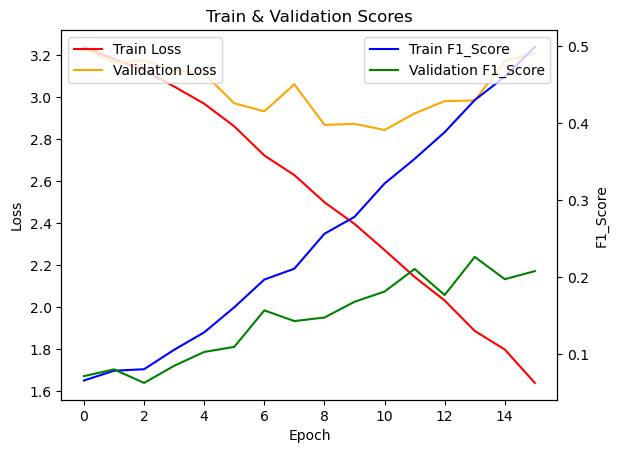

In [58]:
fig, ax1 = plt.subplots()  


ax1.plot(train_report[0], label='Train Loss', color='red')
ax1.plot(val_report[0], label='Validation Loss', color='orange')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(train_report[1], label='Train F1_Score', color='blue')
ax2.plot(val_report[1], label='Validation F1_Score', color='green')
ax2.set_ylabel('F1_Score')
ax2.set_xlabel('Epoch')
ax2.tick_params(axis='y')
ax2.legend(loc='upper right')

plt.xlabel('Epoch')  
plt.title('Train & Validation Scores')
plt.show()